In [1]:
import pandas as pd
import geopandas as gpd
from glob import glob
import folium
from datetime import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

top_sub_path = sorted(glob("../data/raw/top_rent_suburbs_*.csv"))[-1]
top_sub = pd.read_csv(top_sub_path)
top_sub['value_'] = top_sub['value'].copy()
top_sub['value'] = top_sub['value'].str.replace('\$|,','').astype(int)
# scraping results can be downloaded, or obtained and preprocessed through scrape_house_speakingsame_buy|rent.py and preprocess_house_speakingsame.py
rawdf = pd.read_csv(sorted(glob('../data/curated/housespeakingsame/*.csv'))[-1], parse_dates=['rent_date', 'sold_date', 'last_sold_date'])
prox = pd.read_csv(sorted(glob('../data/raw/ORS/sthcrs_*.csv'))[-1], index_col=[0])
prox_lf = rawdf.dropna(subset=['lng','lat']).drop_duplicates(subset=['lng','lat'])[['lng','lat']].copy()
prox_lf[['duration', 'distance']] = prox[['duration','distance']].values.tolist()
rawdf = rawdf.merge(prox_lf, on=['lng','lat'])

<ipython-input-1-044c66aae8dd>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  top_sub['value'] = top_sub['value'].str.replace('\$|,','').astype(int)
<ipython-input-1-044c66aae8dd>:14: DtypeWarning: Columns (5,6,7,10,11,16,18,33) have mixed types. Specify dtype option on import or set low_memory=False.
  rawdf = pd.read_csv(sorted(glob('../data/curated/housespeakingsame/*.csv'))[-1], parse_dates=['rent_date', 'sold_date', 'last_sold_date'])


# Outlier Detection

In [2]:
df = rawdf[['property_type','agent','source','suburb','land_size', 'duration', 'distance',
            'building_size','bed','bath','car','rent_price','rent_date','sold_price','sold_date','last_sold_price','last_sold_date']].copy()
df[['bed','bath','car']] = df[['bed','bath','car']].fillna(0)

In [3]:
# z-scores
cols = ['land_size','building_size','bed','bath','car','rent_price','sold_price','last_sold_price']
for col in cols:
    z = (df[col] - df[col].mean()) / df[col].std()
    df[col+'_out'] = z>3
df['outlier'] = df[[col+'_out' for col in cols]].any(axis=1)

In [4]:
clean_df = df.loc[~df['outlier']].drop([col+'_out' for col in cols] + ['outlier'],axis=1)
clean_df = clean_df.query("rent_price<7000")

# Data

A total of ~80K properties are scraped from the top 200 suburbs by rent value.

These 200 suburbs are discretised into 5 bins. Since the top 2 suburbs are ski resorts with abnormally high rent values, they are assigned their own category manually, then 4 equal width bins are assigned to the remaining 198 suburbs.

In [5]:
top200 = top_sub.head(200).copy()
top200['suburb_category'] = ['vhigh', 'vhigh'] + pd.cut(top200['value'].values[2:], 4, labels=['vlow','low','mid','high']).tolist()
top200['suburb_category'] = pd.Categorical(top200['suburb_category'], categories=['vlow','low','mid','high','vhigh'], ordered=True)

In [6]:
clean_df['suburb_category'] = clean_df['suburb'].map(top200.set_index('suburb')['suburb_category'].to_dict())

Text(0.5, 1.0, 'Average Sold Price')

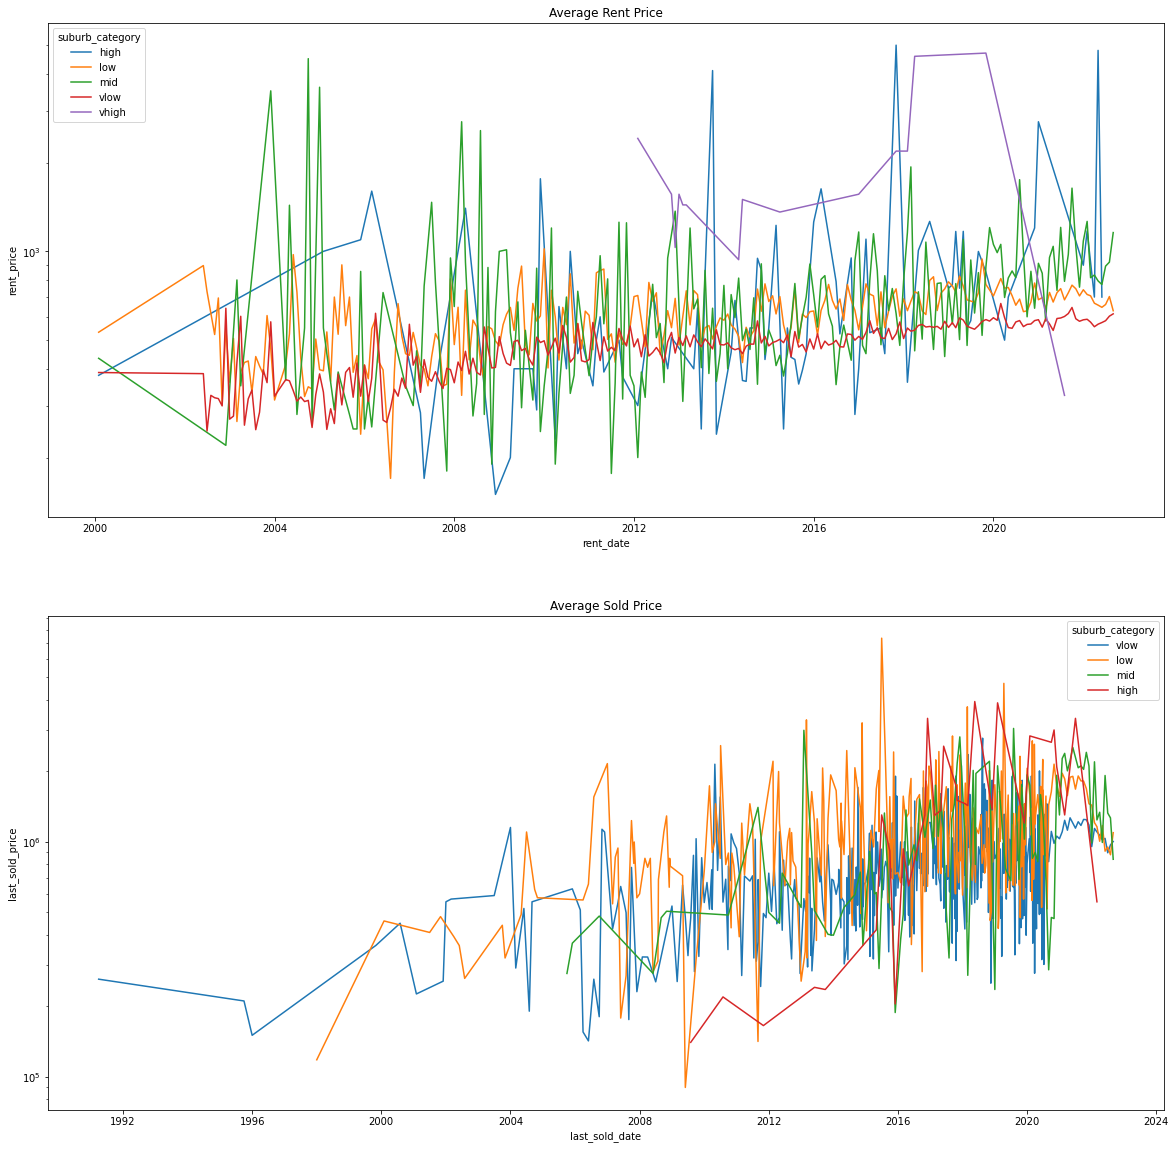

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,20))
sns.lineplot(data=clean_df.groupby(['rent_date','suburb_category'])['rent_price'].mean().reset_index().sort_values("rent_date"), 
             x='rent_date', y='rent_price', hue='suburb_category', ax=ax1)
ax1.set_yscale('log')
ax1.set_title('Average Rent Price')
sns.lineplot(data=clean_df.groupby(['last_sold_date','suburb_category'])['last_sold_price'].mean().reset_index().sort_values("last_sold_date"), 
             x='last_sold_date', y='last_sold_price', hue='suburb_category', ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Average Sold Price')

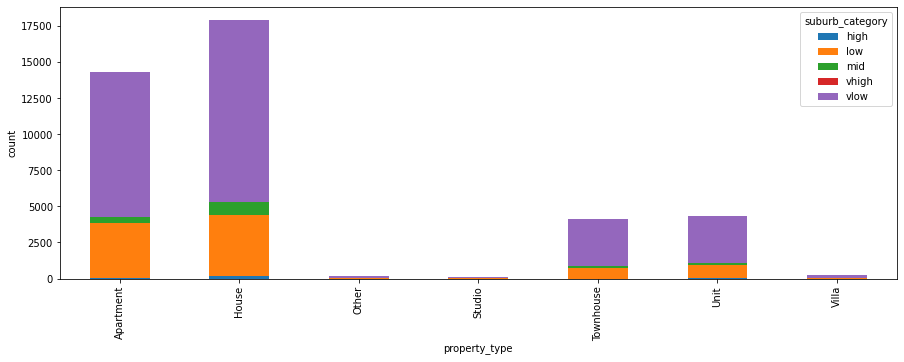

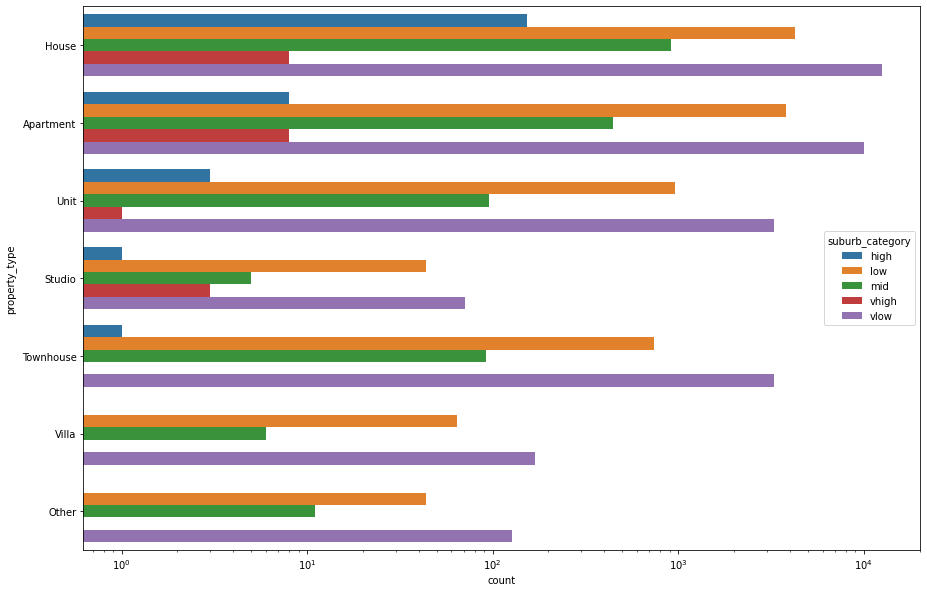

In [8]:
prop_types = clean_df['property_type'].value_counts().loc[clean_df['property_type'].value_counts()>100].index
sub_prop_type_df = clean_df.loc[clean_df['property_type'].isin(prop_types)].groupby('suburb_category')['property_type'].value_counts().reset_index(name='count')

fig, ax = plt.subplots(1,1,figsize=(15,5))
sub_prop_type_df.pivot('property_type','suburb_category','count').fillna(0).plot(kind='bar', stacked=True, ax=ax)
plt.ylabel('count')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(data=sub_prop_type_df, x='count', y='property_type', hue='suburb_category')
ax.set_xscale('log')

# Property Rental Prices

Investigate the predictive power of property, suburb and time specific attributes

property attributes
- rooms
    - bedrooms
    - bathrooms
    - car spaces
- land & building size
- property type
- proximity to stations

suburb
- suburb rent value ranking
- population
- income
- stations
- open street map features

time
- year & month

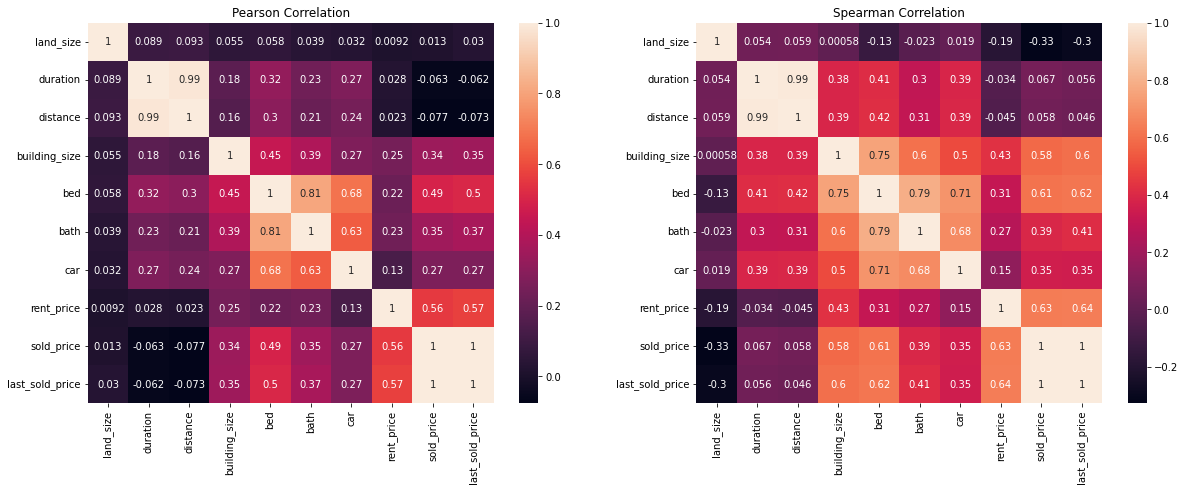

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
sns.heatmap(clean_df.corr(method='pearson'), annot=True, ax=ax1)
ax1.set_title("Pearson Correlation")
sns.heatmap(clean_df.corr(method='spearman'), annot=True, ax=ax2)
ax2.set_title("Spearman Correlation")
None

Except for land size, rent price appears to have some linear correlation with all attributes and comparatively stronger monotonic correlation.

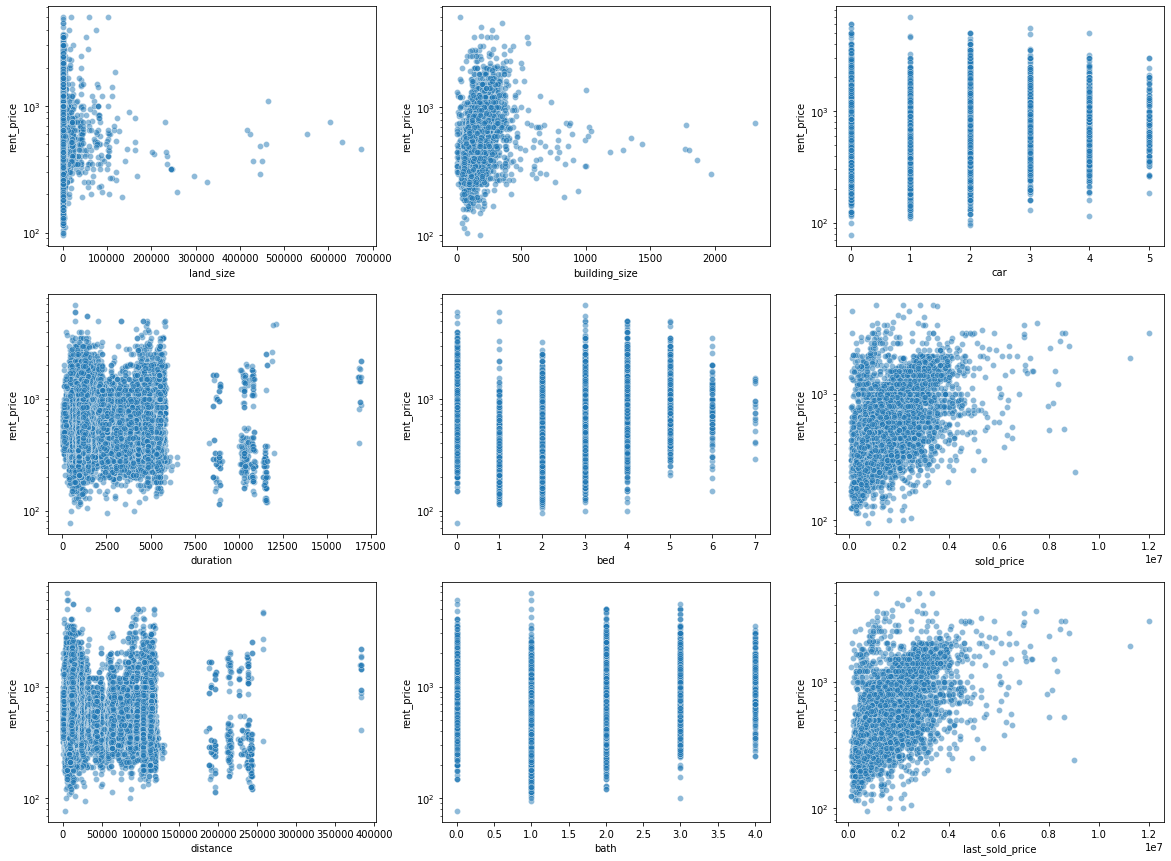

In [10]:
fig, axs = plt.subplots(3,3,figsize=(20,15))
for i, col in enumerate(clean_df.corr().columns.drop('rent_price')):
    ax = axs[i%3][i//3]
    sns.scatterplot(data=clean_df, x=col, y='rent_price', alpha=0.5, ax=ax)
    ax.set_yscale('log')

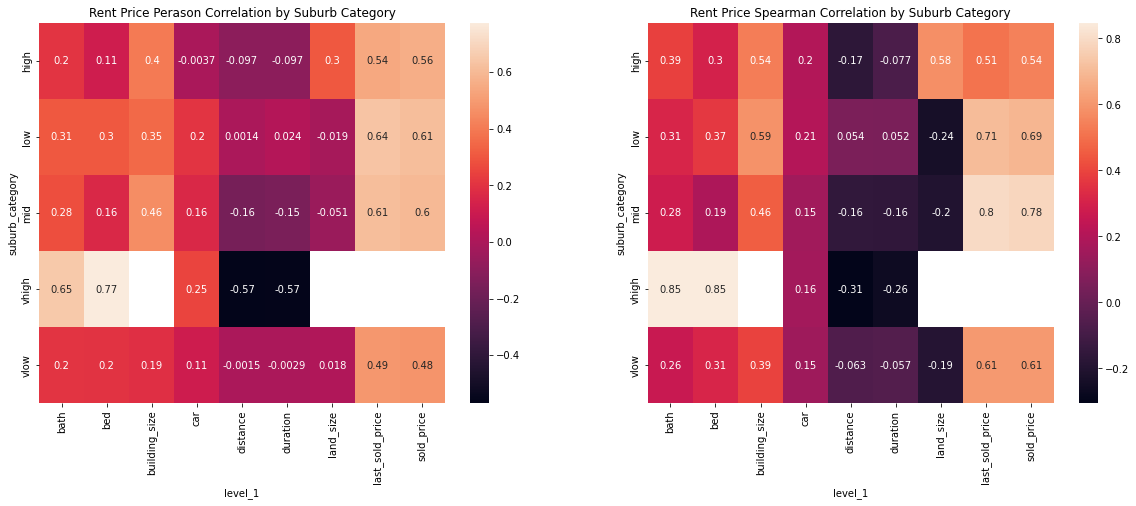

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,7))
sns.heatmap(clean_df.groupby('suburb_category').corr(method='pearson')['rent_price'].dropna().reset_index().pivot('suburb_category','level_1','rent_price').drop('rent_price',axis=1), annot=True, ax=ax1)
ax1.set_title("Rent Price Perason Correlation by Suburb Category")
sns.heatmap(clean_df.groupby('suburb_category').corr(method='spearman')['rent_price'].dropna().reset_index().pivot('suburb_category','level_1','rent_price').drop('rent_price',axis=1), annot=True, ax=ax2)
ax2.set_title("Rent Price Spearman Correlation by Suburb Category")
None

Grouping by suburb category, we observe much higher linear correlation with rent price in the lower range suburbs, which is feasible due to the exponential differences between suburb categories

# Suburb Growth

In [12]:
import statsmodels.formula.api as smf

/home/tz/.local/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Population Growth

In [13]:
popdf = pd.read_excel('../data/raw/abs_data/pop_deaths.xlsx', sheet_name = 2, skiprows = 4, header = [0,1], nrows = 129)[1:]
popdf = popdf.drop([(y, 'Standardised death rate.1') for y in range(2012, 2020)], axis=1)
popdf = popdf.drop([(y, 'Standardised death rate') for y in range(2012, 2021)], axis=1)
popdf.columns = [('LGA Code'), ('LGA Name')] + [','.join([str(c) for c in x]) for x in popdf.columns[2:]]
popdf2 = popdf.melt(id_vars=["LGA Code", "LGA Name"])
popdf2 = popdf2.dropna()
popdf2['value'] = popdf2.value.astype('int')
popdf2[['year','var']] = popdf2['variable'].str.split(',').tolist()
popdf2['year'] = popdf2['year'].astype(int)
popdf2 = popdf2.sort_values('year')
# Forecasting population
popdf3 = popdf2.loc[popdf2['var'] == 'Estimated resident population'].copy()
popdf3['growth'] = popdf3.groupby(['LGA Code', 'LGA Name'])['value'].apply(pd.Series.pct_change)

Text(0.5, 1.0, 'Population Growth Rate of LGA')

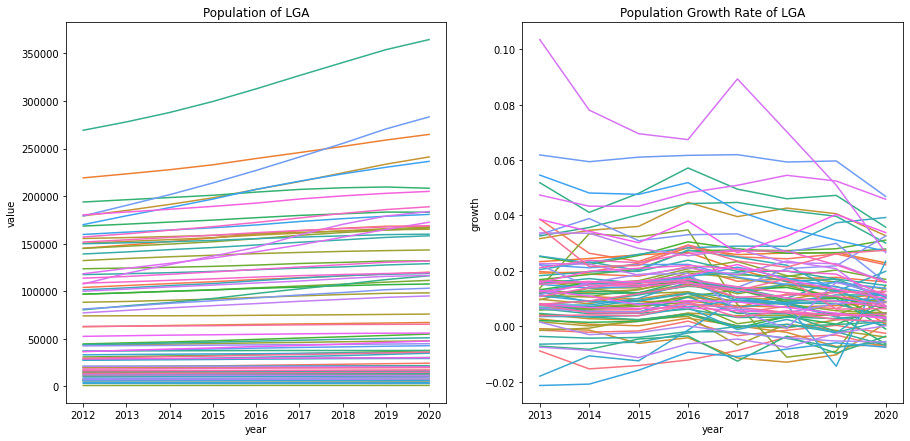

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
sns.lineplot(data=popdf3, x='year', y='value', hue='LGA Name', ax=ax1)
ax1.get_legend().remove()
ax1.set_title("Population of LGA")
sns.lineplot(data=popdf3, x='year', y='growth', hue='LGA Name', ax=ax2)
ax2.get_legend().remove()
ax2.set_title("Population Growth Rate of LGA")

In [15]:
pop_df = pd.DataFrame()
for (name, code), d in popdf3.dropna(subset='growth').groupby(['LGA Name', 'LGA Code']):
    d = d[['year','growth']]
    mod = smf.ols(formula="growth~year", data=d).fit()
    d_forecast = pd.DataFrame({'year': list(range(2000,2013)) + list(range(2021,2029))})
    d_forecast['growth'] = mod.predict(d_forecast)
    new = pd.concat([d, d_forecast])
    new['LGA Name'] = name
    new['LGA Code'] = code
    pop_df = pd.concat([pop_df, new]).reset_index(drop=True)

Text(0.5, 1.0, 'Population Growth of LGA')

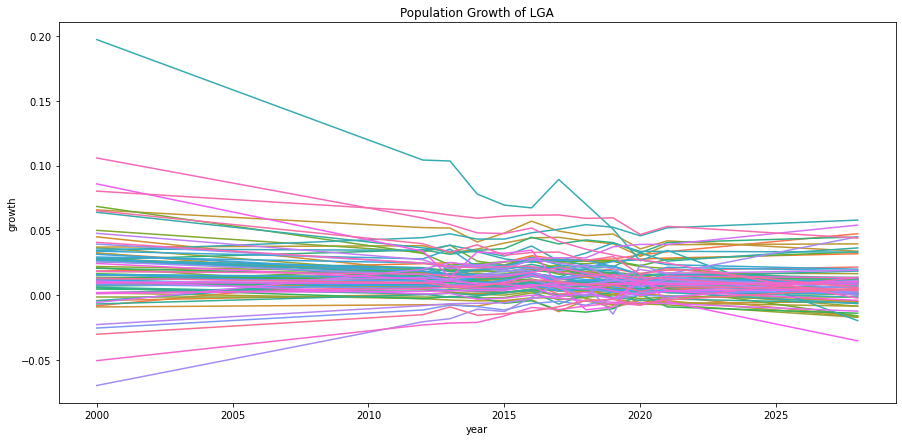

In [16]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
sns.lineplot(data=pop_df, x='year', y='growth', hue='LGA Name', ax=ax)
ax.get_legend().remove()
ax.set_title("Population Growth of LGA")

In [17]:
# pop_df.merge(popdf3, on=['year','LGA Name', 'LGA Code'])

## LGA Suburb Merge

In [18]:
SAL_PATH = "../data/raw/lga_conversion/SAL_2021_AUST.csv"
LGA_PATH = "../data/raw/lga_conversion/LGA_2021_AUST.csv"
# MB_PATH = "../data/raw/lga_conversion/MB_2021_AUST.csv"
sal_df = pd.read_csv(SAL_PATH).query('STATE_NAME_2021=="Victoria"')
lga_df = pd.read_csv(LGA_PATH).query('STATE_NAME_2021=="Victoria"')
# mb_df = pd.read_csv(MB_PATH).query('STATE_NAME_2021=="Victoria"')

<ipython-input-18-516ba729e3f1>:4: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  sal_df = pd.read_csv(SAL_PATH).query('STATE_NAME_2021=="Victoria"')
<ipython-input-18-516ba729e3f1>:5: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  lga_df = pd.read_csv(LGA_PATH).query('STATE_NAME_2021=="Victoria"')


In [19]:
sal_df['suburb'] = sal_df['SAL_NAME_2021'].str.replace(' \([^\(\)]+\)', '').apply(lambda x: 'Preston West' if x=='Preston' else x)

<ipython-input-19-9ad6728baeed>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  sal_df['suburb'] = sal_df['SAL_NAME_2021'].str.replace(' \([^\(\)]+\)', '').apply(lambda x: 'Preston West' if x=='Preston' else x)


In [20]:
pop_df2 = sal_df.merge(lga_df[['MB_CODE_2021','LGA_CODE_2021']], on='MB_CODE_2021')[[
    'SAL_NAME_2021', 'MB_CODE_2021', 'LGA_CODE_2021', 'suburb']].drop_duplicates().merge(
    pop_df, left_on='LGA_CODE_2021', right_on='LGA Code')

In [21]:
clean_df[['suburb']].drop_duplicates().merge(pop_df2, on='suburb', how='left')

,suburb,SAL_NAME_2021,MB_CODE_2021,LGA_CODE_2021,year,growth,LGA Name,LGA Code
0,Mentone,Mentone,20309670000,23430,2013.0,0.012637,Kingston (C) (Vic.),23430.0
1,Mentone,Mentone,20309670000,23430,2014.0,0.012302,Kingston (C) (Vic.),23430.0
2,Mentone,Mentone,20309670000,23430,2015.0,0.013190,Kingston (C) (Vic.),23430.0
3,Mentone,Mentone,20309670000,23430,2016.0,0.017261,Kingston (C) (Vic.),23430.0
4,Mentone,Mentone,20309670000,23430,2017.0,0.013275,Kingston (C) (Vic.),23430.0
...,...,...,...,...,...,...,...,...
685585,Mount Buller,Mount Buller,20663885000,29399,2024.0,-0.017782,Unincorporated Vic,29399.0
685586,Mount Buller,Mount Buller,20663885000,29399,2025.0,-0.022100,Unincorporated Vic,29399.0
685587,Mount Buller,Mount Buller,20663885000,29399,2026.0,-0.026418,Unincorporated Vic,29399.0
685588,Mount Buller,Mount Buller,20663885000,29399,2027.0,-0.030736,Unincorporated Vic,29399.0


## Rent Growth

In [22]:
clean_df['rent_year'] = clean_df['rent_date'].dt.year

In [23]:
def calc_growth(d):
    year, value = d['rent_year'], d['value']
    return pd.Series.pct_change(value)/year.diff()
sub_year_df = clean_df.groupby(['suburb','rent_year'])['rent_price'].mean().reset_index(name='value')
sub_year_df['growth/yr'] = sub_year_df.groupby('suburb').apply(calc_growth).values

In [24]:
sub_year_df = sub_year_df.merge(pop_df2[['suburb','year','growth']].drop_duplicates().rename(
    {'year':'rent_year','growth':'population'},axis=1), on=['suburb','rent_year'], how='left')#.dropna()

In [25]:
top_growth = sub_year_df.groupby('suburb')['growth/yr'].mean().sort_values()
top_growth

suburb
Mount Buller         -0.096759
St Kilda East         0.009361
St Helena             0.016208
Cheltenham            0.017131
Mont Albert North     0.018478
                        ...   
Shoreham              0.457663
Buln Buln             0.476310
Somers                0.496066
Sawmill Settlement    0.596122
Moorooduc             0.788340
Name: growth/yr, Length: 200, dtype: float64

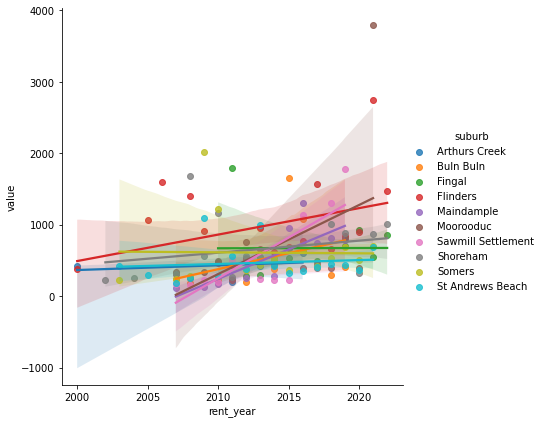

In [26]:
g = sns.lmplot(data=sub_year_df.loc[sub_year_df['suburb'].isin(top_growth.tail(10).index)], height=6,
             x='rent_year', y='value', hue='suburb')

Text(0.5, 1.0, 'Top 10 Suburb Growth Rates Per Year')

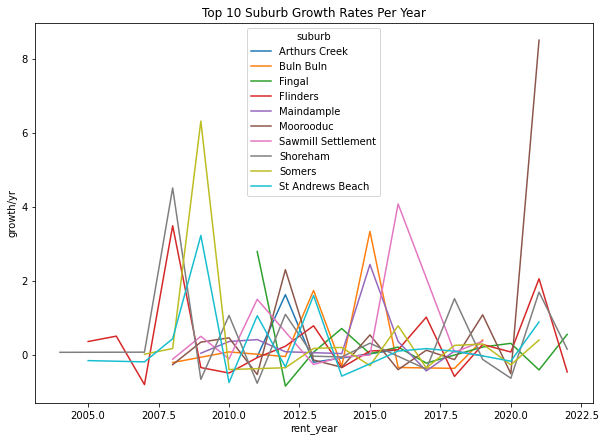

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=sub_year_df.loc[sub_year_df['suburb'].isin(top_growth.tail(10).index)],
            x='rent_year', y='growth/yr', hue='suburb')
ax.set_title("Top 10 Suburb Growth Rates Per Year")

## By Linear Regression

In [28]:
top_growth = mod.params.loc[mod.params.index.str.match('^rent_year:')].sort_values()
top10growth = top_growth.tail(10).index.str.extract(r"T\.([\w\s]+)\]").values.reshape(-1)

In [29]:
mod = smf.ols(formula="value~rent_year+C(suburb)+rent_year*C(suburb)",data=sub_year_df).fit()

In [30]:
top_growth_lin = mod.params.loc[mod.params.index.str.match('^rent_year:')].sort_values()
top10growth = top_growth_lin.tail(10).index.str.extract(r"T\.([\w\s]+)\]").values.reshape(-1)

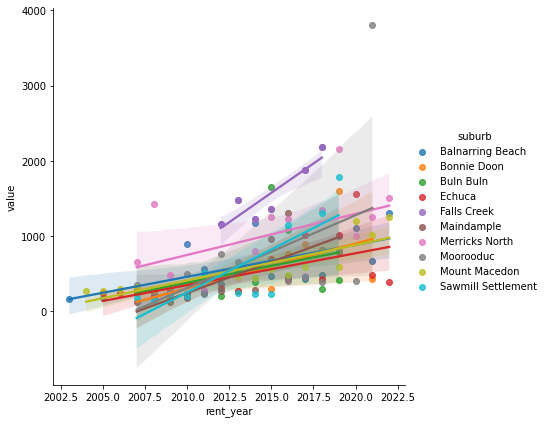

In [31]:
top10growth_sub = sub_year_df.loc[sub_year_df['suburb'].isin(top10growth)].copy()
g2 = sns.lmplot(data=top10growth_sub, height=6,
             x='rent_year', y='value', hue='suburb')